In [1]:
import awkward as ak
import uproot
import hist as hs
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
import scipy.optimize

from coffea.nanoevents import NanoEventsFactory, BaseSchema, NanoAODSchema, TreeMakerSchema, PHYSLITESchema
from coffea.nanoevents.methods import vector

In [2]:
rootdir = "rootfiles/"
samples = {}
samples["sigevents1GeV_ctau1000"] = NanoEventsFactory.from_root(
    uproot.open(rootdir + 'BToKPhi_MuonGenFilter_mPhi1p0_ctau1000_1pb_weighted.root'),
    treepath='MuonSystem',
    # entry_stop=100000,
    #metadata={"dataset": "llp"},
    schemaclass=BaseSchema,
).events()

samples["sigevents0_3GeV_Pi0Pi0_ctau1000"] = NanoEventsFactory.from_root(
    uproot.open(rootdir + 'BToKPhi_MuonGenFilter_PhiToPi0Pi0_mPhi0p3_ctau1000_1pb_weighted.root'),
    treepath='MuonSystem',
    # entry_stop=100000,
    #metadata={"dataset": "llp"},
    schemaclass=BaseSchema,
).events()

samples["sigevents0_3GeV_Pi0Pi0_ctau300"] = NanoEventsFactory.from_root(
    uproot.open(rootdir + 'BToKPhi_MuonGenFilter_PhiToPi0Pi0_mPhi0p3_ctau300_1pb_weighted.root'),
    treepath='MuonSystem',
    # entry_stop=100000,
    # metadata={"dataset": "llp"},
    schemaclass=BaseSchema,
).events()

samples["sigevents0_3GeV_PiPlusPiMinus_ctau300"] = NanoEventsFactory.from_root(
    uproot.open(rootdir + 'BToKPhi_MuonGenFilter_PhiToPiPlusPiMinus_mPhi0p3_ctau300_1pb_weighted.root'),
    treepath='MuonSystem',
    # entry_stop=100000,
    #metadata={"dataset": "llp"},
    schemaclass=BaseSchema,
).events()

samples["sigevents0_3GeV_PiPlusPiMinus_ctau1000"] = NanoEventsFactory.from_root(
    uproot.open(rootdir + 'BToKPhi_MuonGenFilter_PhiToPiPlusPiMinus_mPhi0p3_ctau1000_1pb_weighted.root'),
    treepath='MuonSystem',
    # entry_stop=100000,
    #metadata={"dataset": "llp"},
    schemaclass=BaseSchema,
).events()

In [3]:
def delta_cls_gLLP(events):
    clusts = ak.zip(
        {
            'pt': ak.zeros_like(events.cscRechitClusterPhi),
            'phi': events.cscRechitClusterPhi,
            'eta': events.cscRechitClusterEta,
            'E': ak.zeros_like(events.cscRechitClusterPhi),
        },
        with_name = 'PtEtaPhiMLorentzVector',
        behavior = vector.behavior,                 
      )
    gLLPs = ak.zip(
        {
            'pt': events.gLLP_pt,
            'phi': events.gLLP_phi,
            'eta': events.gLLP_eta,
            'E': events.gLLP_e,
        },
        with_name = 'PtEtaPhiMLorentzVector',
        behavior = vector.behavior,                 
      )        
    cls_llp_pairs = ak.cartesian({
        "cls": clusts, 
        "llp": gLLPs
    }, nested = True) 

    deltaR = (cls_llp_pairs.cls).delta_r(cls_llp_pairs.llp)
    deltaEta = abs(cls_llp_pairs.cls.eta - cls_llp_pairs.llp.eta)
    deltaPhi = np.arctan2(np.sin(cls_llp_pairs.cls.phi - cls_llp_pairs.llp.phi), 
                          np.cos(cls_llp_pairs.cls.phi - cls_llp_pairs.llp.phi))

    return ak.flatten(deltaR, axis=2), ak.flatten(deltaEta, axis=2), ak.flatten(deltaPhi, axis=2)

def delta_cls_leadmuon(events):
    clusts = ak.zip(
        {
            'pt': ak.zeros_like(events.cscRechitClusterPhi),
            'phi': events.cscRechitClusterPhi,
            'eta': events.cscRechitClusterEta,
            'E': ak.zeros_like(events.cscRechitClusterPhi),
        },
        with_name = 'PtEtaPhiMLorentzVector',
        behavior = vector.behavior,                 
      )
    leadMuons = ak.zip(
        {
            'pt': events.leadMuonPt,
            'phi': events.leadMuonPhi,
            'eta': events.leadMuonEta,
            'E': events.leadMuonE,
        },
        with_name = 'PtEtaPhiMLorentzVector',
        behavior = vector.behavior,                 
      ) 
    cls_muon_pairs = ak.cartesian({
        "cls": clusts, 
        "muon": leadMuons
    }, nested = True)

    deltaR = (cls_muon_pairs.cls).delta_r(cls_muon_pairs.muon)
    deltaEta = abs(cls_muon_pairs.cls.eta - cls_muon_pairs.muon.eta)
    deltaPhi = np.arctan2(np.sin(cls_muon_pairs.cls.phi - cls_muon_pairs.muon.phi), 
                          np.cos(cls_muon_pairs.cls.phi - cls_muon_pairs.muon.phi))

    return ak.flatten(deltaR, axis=2), ak.flatten(deltaEta, axis=2), ak.flatten(deltaPhi, axis=2)

In [4]:
def cutstrigger(events, dataset):

    muoncut = abs(events.lepPdgId) == 13
    events['muonE'] = events.lepE[muoncut]
    events['muonPt'] = events.lepPt[muoncut]
    events['muonEta'] = events.lepEta[muoncut]
    events['muonPhi'] = events.lepPhi[muoncut]
    events['muonPdgId'] = events.lepPdgId[muoncut]
    events['muonDZ'] = events.lepDZ[muoncut]
    events['muonLooseId'] = events.lepLooseId[muoncut]
    events['muonTightId'] = events.lepTightId[muoncut] 
    # events['muonType'] = events.lepMuonType[muoncut]
    # events['muonQuality'] = events.lepMuonQuality[muoncut]
    # events['muon_passHLTFilter'] = events.lepMuon_passHLTFilter[muoncut]
    events = events[ak.count(events.muonPt, axis=1) > 0] #kill all events with empty muons

        # cut and mutate events based on this new branch
    def muoncutter(events, muoncut):
        events['muonE'] = events.muonE[muoncut]
        events['muonPt'] = events.muonPt[muoncut]
        events['muonEta'] = events.muonEta[muoncut]
        events['muonPhi'] = events.muonPhi[muoncut]
        events['muonPdgId'] = events.muonPdgId[muoncut]
        events['muonDZ'] = events.muonDZ[muoncut]
        events['muonLooseId'] = events.muonLooseId[muoncut]
        events['muonTightId'] = events.muonTightId[muoncut]
        # events['muonType'] = events.muonType[muoncut]
        # events['muonQuality'] = events.muonQuality[muoncut]
        # events['muon_passHLTFilter'] = events.muon_passHLTFilter[muoncut]
        return events[ak.count(events.muonPt, axis=1) > 0] #kill all events with empty muons

    events = muoncutter(events, abs(events.muonEta) < 1.5)
    events = muoncutter(events, events.muonPt > 7)
    # events = muoncutter(events, ak.any(events.muon_passHLTFilter[:,:,range(60,68)], axis=2))
    # events = muoncutter(events, events.muonQuality >= 2**25)


        # finally keep only the leading muon
    leadcut = (ak.max(events.muonPt, axis=1, mask_identity=True) == events.muonPt)
    events['leadMuonE'] = events.muonE[leadcut][:,0]
    events['leadMuonPt'] = events.muonPt[leadcut][:,0]
    events['leadMuonEta'] = events.muonEta[leadcut][:,0]
    events['leadMuonPhi'] = events.muonPhi[leadcut][:,0]
    events['leadMuonPdgId'] = events.muonPdgId[leadcut][:,0]
    events['leadMuonDZ'] = events.muonDZ[leadcut][:,0]
    events['leadMuonLooseId'] = events.muonLooseId[leadcut][:,0]
    events['leadMuonTightId'] = events.muonTightId[leadcut][:,0]
    # events['leadMuonType'] = events.muonType[leadcut][:,0]
    # events['leadMuonQuality'] = events.muonQuality[leadcut][:,0]
    # events['leadMuon_passHLTFilter'] = events.muon_passHLTFilter[leadcut][:,0]    
    
    HLT_MU_IP_sel = range(1157,1197)
    return events[ak.any(events.HLTDecision[:,HLT_MU_IP_sel], axis=1)]

In [5]:
def cutsfull(events, dataset):

    events = cutstrigger(events, dataset)

    if 'signal' in dataset:
        cls_llp_deltaR, cls_llp_deltaEta, cls_llp_deltaPhi = delta_cls_gLLP(events)
        events['cscRechitCluster_llp_deltaR'] = cls_llp_deltaR
        events['cscRechitCluster_llp_deltaEta'] = cls_llp_deltaEta
        events['cscRechitCluster_llp_deltaPhi'] = cls_llp_deltaPhi

    cls_leadmuon_deltaR, cls_leadmuon_deltaEta, cls_leadmuon_deltaPhi = delta_cls_leadmuon(events)
    events['cscRechitCluster_leadmuon_deltaR'] = cls_leadmuon_deltaR
    events['cscRechitCluster_leadmuon_deltaEta'] = cls_leadmuon_deltaEta
    events['cscRechitCluster_leadmuon_deltaPhi'] = cls_leadmuon_deltaPhi

    cscCuts = ak.values_astype(ak.ones_like(events.nCscRechitClusters), 'bool')

    cscCuts = cscCuts & (events.nCscRechitClusters >= 1)
    if 'signal' in dataset:
        cscCuts = cscCuts &  (events.gLLP_csc == 1) 

    cscCuts = cscCuts & (events.cscRechitCluster_leadmuon_deltaR > .8) 

    cscCuts = cscCuts & ((events.cscRechitClusterNRechitChamberPlus11 <= 0)&
                         (events.cscRechitClusterNRechitChamberMinus11 <= 0)) 

    cscCuts = cscCuts & ((events.cscRechitClusterNRechitChamberPlus12 <= 0)&
                         (events.cscRechitClusterNRechitChamberMinus12 <= 0)) 

    cscCuts = cscCuts & (events.cscRechitCluster_match_RE12_0p4 == 0)
    cscCuts = cscCuts & (events.cscRechitCluster_match_MB1Seg_0p4 == 0)
    cscCuts = cscCuts & (events.cscRechitCluster_match_RB1_0p4 == 0)
    cscCuts = cscCuts & (events.cscRechitClusterMuonVetoPt < 20)

    cscCuts = cscCuts & ((events.cscRechitClusterTimeWeighted <= 12.5)&
                               (events.cscRechitClusterTimeWeighted >= -5  ))

    cscCuts = cscCuts & (events.cscRechitClusterTimeSpreadWeightedAll <= 20)
    cscCuts = cscCuts & (abs(events.cscRechitClusterEta) < 1.9)
    cscCuts = cscCuts & (events.cscRechitClusterSize > 130)

    cscCuts = cscCuts & (
   ((events.cscRechitClusterNStation10 >  1)                                                   & (abs(events.cscRechitClusterEta) < 1.9)) |
   ((events.cscRechitClusterNStation10 == 1) & (abs(events.cscRechitClusterAvgStation10) == 4) & (abs(events.cscRechitClusterEta) < 1.8)) |
   ((events.cscRechitClusterNStation10 == 1) & (abs(events.cscRechitClusterAvgStation10) == 3) & (abs(events.cscRechitClusterEta) < 1.6)) |
   ((events.cscRechitClusterNStation10 == 1) & (abs(events.cscRechitClusterAvgStation10) == 2) & (abs(events.cscRechitClusterEta) < 1.6)) |
   ((events.cscRechitClusterNStation10 == 1) & (abs(events.cscRechitClusterAvgStation10) == 1) & (abs(events.cscRechitClusterEta) < 1.1))
   )

    if cscCuts.layout.minmax_depth == (2,2):
        outcut = ak.any(cscCuts, axis=1)
    elif bigCut.layout.minmax_depth == (1,1):
        outcut = cscCuts
    
    
    return events[outcut]

In [6]:
def efplotter(events, label, oldctau, ax):
    
    cutevents = cutstrigger(events, 'signal')

    eff_sig_old = sum(cutevents.gLLP_csc == 1)/len(cutevents)
    
    def weight_calc(llp_ct, new_ctau, old_ctau):
        return (old_ctau/new_ctau) * np.exp(llp_ct*(1/old_ctau - 1/new_ctau))

    ctau_list = np.logspace(-.3, 4, 50)
    eff = []
    
    cut = cutevents.gLLP_csc == 1
    gLLP_ctau = cutevents.gLLP_ctau[cut] #cuts gLLP_ctau
    
    for ct in ctau_list:
        weight_ctau = weight_calc(gLLP_ctau, ct, oldctau) # convert everything to cm
        eff_sig = eff_sig_old*np.sum(weight_ctau)/len(weight_ctau)
        eff.append(eff_sig)
        
    ax.plot(ctau_list, eff, label = label)
    print(f"{label}, {sum(cut)}")
    del events, cut
    gc.collect()


In [7]:
def brplotter(events, label, oldctau, ax):
    
    cutevents = cutsfull(events, 'signal')
    
    eff_sig_old = sum(cutevents.gLLP_csc == 1)/len(cutevents)
    
    def weight_calc(llp_ct, new_ctau, old_ctau):
        return (old_ctau/new_ctau) * np.exp(llp_ct*(1/old_ctau - 1/new_ctau))
    
    ctau_list = np.logspace(-.3, 4, 50)
    br = []

    cut = cutevents.gLLP_csc == 1
    gLLP_ctau = cutevents.gLLP_ctau[cut] #cuts gLLP_ctau
    
    nb = 94
    frac_of_B = .02
    BR_old = 2*np.sqrt(nb/frac_of_B)/(5e9*eff_sig_old)

    for ct in ctau_list:
        weight_ctau = weight_calc(gLLP_ctau, ct, oldctau) # convert everything to cm
        br.append(BR_old/sum(weight_ctau))
        
    ax.plot(ctau_list, br, label = label)
    print(f"{label}, {sum(cut)}")
    del events, cut
    gc.collect()


φ→π0π0; ctau = 100cm; m = 1.0Gev, 8034


MemoryError: std::bad_alloc

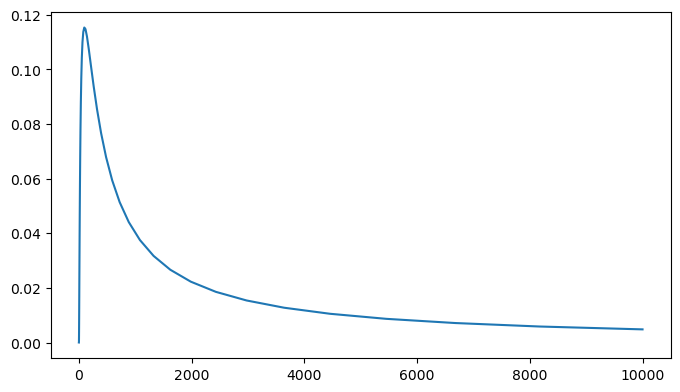

In [8]:
import matplotlib.pyplot as plt
import gc

a = .5
fig, ax = plt.subplots(figsize = (a*16,a*9)) 
gc.collect()
efplotter(samples["sigevents1GeV_ctau1000"], "φ→π0π0; ctau = 100cm; m = 1.0Gev", 100, ax)
# del samples["sigevents1GeV_ctau1000"]
# gc.collect()
efplotter(samples["sigevents0_3GeV_PiPlusPiMinus_ctau1000"], "φ→π+π-; ctau =  100cm; m = 0.3Gev", 100, ax)
# # del samples["sigevents0_3GeV_PiPlusPiMinus_ctau1000"]
# # gc.collect()
efplotter(samples["sigevents0_3GeV_PiPlusPiMinus_ctau300"], "φ→π+π-; ctau =  30cm; m = 0.3Gev", 30, ax)
# # del samples["sigevents0_3GeV_PiPlusPiMinus_ctau300"]
# # gc.collect()
efplotter(samples["sigevents0_3GeV_Pi0Pi0_ctau1000"], "φ→π0π0; ctau =  100cm; m = 0.3Gev", 100, ax)
# # del samples["sigevents0_3GeV_Pi0Pi0_ctau1000"]
# # gc.collect()
efplotter(samples["sigevents0_3GeV_Pi0Pi0_ctau300"], "φ→π0π0; ctau =  30cm; m = 0.3Gev", 30, ax)
# # del samples["sigevents0_3GeV_Pi0Pi0_ctau300"]
# # gc.collect()

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("ctau' (mm)")
ax.set_ylabel("eff'")
ax.legend()
ax.grid()
plt.show()




φ→π0π0; ctau = 100cm; m = 1.0Gev, 83514


MemoryError: std::bad_alloc

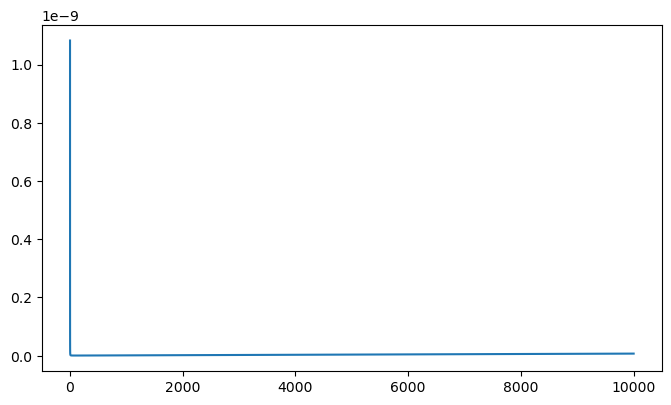

In [10]:
import gc
import matplotlib.pyplot as plt
gc.collect()

a = .5
fig, ax = plt.subplots(figsize = (a*16,a*9)) 

brplotter(samples["sigevents1GeV_ctau1000"], "φ→π0π0; ctau = 100cm; m = 1.0Gev", 100, ax)
# del events["sigevents1GeV_ctau1000"]
# gc.collect()
# brplotter(samples["sigevents0_3GeV_PiPlusPiMinus_ctau1000"], "φ→π+π-; ctau =  100cm; m = 0.3Gev", 100, ax)
# # del events["sigevents0_3GeV_PiPlusPiMinus_ctau1000"]
# # gc.collect()
brplotter(samples["sigevents0_3GeV_PiPlusPiMinus_ctau300"], "φ→π+π-; ctau =  30cm; m = 0.3Gev", 30, ax)
# # del events["sigevents0_3GeV_PiPlusPiMinus_ctau300"]
# # gc.collect()
# brplotter(samples["sigevents0_3GeV_Pi0Pi0_ctau1000"], "φ→π0π0; ctau =  100cm; m = 0.3Gev", 100, ax)
# # del events["sigevents0_3GeV_Pi0Pi0_ctau1000"]
# # gc.collect()
# brplotter(samples["sigevents0_3GeV_Pi0Pi0_ctau300"], "φ→π0π0; ctau =  30cm; m = 0.3Gev", 30, ax)
# # del events["sigevents0_3GeV_Pi0Pi0_ctau300"]
# # gc.collect()

plt.xscale("log")
plt.yscale("log")
plt.xlabel("ctau (cm)")
plt.ylabel("BR")
plt.legend()
plt.show()

In [ ]:
import scipy.optimize
import mplhep as hep

# <<< events with trigger cuts <<<
# events1000 = cuts2(events["sigevents0_3GeV_Pi0Pi0_ctau1000"], 'signal')
# events300 = cuts2(events["sigevents0_3GeV_Pi0Pi0_ctau300"], 'signal')
# >>> events with trigger cuts >>>

# <<< events with no cuts <<<
events1000 = events["sigevents0_3GeV_Pi0Pi0_ctau1000"]
events300 = events["sigevents0_3GeV_Pi0Pi0_ctau300"]
# >>> events with no cuts >>>

# <<< llp ctau's <<<
gLLP_ctau1000 = ak.flatten(events1000.gLLP_ctau, axis=None)
gLLP_ctau300 = ak.flatten(events300.gLLP_ctau, axis=None)
# >>> llp ctau's >>>

# <<< reweighting func <<<
def weight_calc(llp_ct, new_ctau, old_ctau):
    return (old_ctau/new_ctau) * np.exp(llp_ct*(1/old_ctau - 1/new_ctau)) #! I can't find what's wrong here, maybe something subtle?
# >>> reweighting func >>>

# <<< plot domain <<<
bins = 30
ct0 = 0
ctf = 1e3
# >>> plot domain >>>

# <<< initialize hist <<<
hist300 = hs.Hist.new.Reg(bins, ct0, ctf).Double()
hist13 = hs.Hist.new.Reg(bins, ct0, ctf).Double()
# >>> initialize hist >>>

# <<< fill histograms <<<
hist300.fill(gLLP_ctau300, weight = 1/len(gLLP_ctau300)) #! normalized
hist13.fill(gLLP_ctau1000, weight = weight_calc(gLLP_ctau1000, 30, 100)/len(gLLP_ctau1000)) #! reweighted and normalized
# >>> fill histograms >>>

# <<< plot histograms <<<
hep.histplot(hist13, label="1000->300")
hep.histplot(hist300, label="300")
plt.legend()
plt.yscale('log')
plt.show()
print(hist13.sum(), hist300.sum())
# >>> plot histograms >>>

In [ ]:
weights = weight_calc(gLLP_ctau1000, 30, 100)
for i, (w, l) in enumerate(zip(weights, gLLP_ctau1000)):
    print(f"{w}, {l}")
    if i>100: break

In [ ]:
for sample in events:
    
    bins = 90
    ct0 = 0
    ctf = 1e3
    ctauhist = hs.Hist.new.Reg(bins, ct0, ctf).Double()
    ctauhist.fill(events[sample].gLLP_ctau)
#    ctauh = ctauhist/ctauhist.sum()
    ctauh = ctauhist

    hep.histplot(ctauh, label = sample)
    
    def monoExpZeroB(t, m, ct):
        return m * np.exp(-t / ct)
    
    ys = ctauh.view()
    ts = np.linspace(ct0,ctf,bins)
    
    # perform the fit using the function where B is 0
    p0 = (1e5, 70) # start with values near those we expect
    paramsB, cv = scipy.optimize.curve_fit(monoExpZeroB, ts, ys, p0)
    mB, tB = paramsB

    # compare this curve to the original
    ysFit = monoExpZeroB(ts, mB, tB)
    plt.plot(ts, ysFit, '--', label=f"ctau = {(tB*10):.{4}g} mm")
    
    plt.legend()
    plt.yscale('log')
    plt.xlabel("ctau")
    plt.show()
    
    bins = 180
    ct0 = 0
    ctf = 1.5
    
    mhist = hs.Hist.new.Reg(bins, ct0, ctf).Double()
    mhist.fill(np.sqrt(events[sample].gLLP_e**2 - (events[sample].gLLP_pt*np.cosh(events[sample].gLLP_eta))**2))
    #mh = mhist/mhist.sum()
    mh = mhist
    hep.histplot(mh, label = sample)
    
    def gaus(m, a, mu, sig):
        return a * np.exp(-(m - mu)**2/(2*sig**2))
    
    ys = mh.view()
    ts = np.linspace(ct0,ctf,bins)
    
    # perform the fit using the function where B is 0
    if '1GeV' in sample:
        p0 = (4e5, 1, .003)
    else:
        p0 = (4e5, .3, .003) # start with values near those we expect
    paramsB, cv = scipy.optimize.curve_fit(gaus, ts, ys, p0)
    aB, muB, sigB = paramsB

    # compare this curve to the original
    ysFit = gaus(ts, aB, muB, sigB)
    plt.plot(ts, ysFit, '--', label=f"mass = {(muB):.{4}g} GeV\nwidth = {(sigB):.{4}g} GeV")

    cutoff = .1
    perc = mh[0:cutoff*1j].sum()/mh.sum()
    plt.vlines(x=cutoff, ymin=plt.gca().get_ylim()[0], ymax=plt.gca().get_ylim()[1], colors='red', ls=':', lw=2, label=f'% before cuttoff = {(perc*100):.{2}g}%')

    plt.legend()
    #plt.yscale('log')
    plt.xlabel("mass")
    plt.show()

In [ ]:
events["sigevents0_3GeV_Pi0Pi0_ctau1000"].fields

In [ ]:
ak.max(abs(events["sigevents1GeV_ctau1000"].gLLP_decay_vertex_z))

In [ ]:
events["sigevents0_3GeV_Pi0Pi0_ctau1000"].nDtRings

In [ ]:
Aevents["sigevents0_3GeV_PiPlusPiMinus_ctau1000"] = NanoEventsFactory.from_root(
    uproot.open(rootdir + 'BToKPhi_MuonGenFilter_PhiToPiPlusPiMinus_mPhi0p3_ctau1000_1pb_weighted.root'),
    treepath='MuonSystem',
    # entry_stop=10000,
    #metadata={"dataset": "llp"},
    schemaclass=BaseSchema,
).events()

cscCuts = {
    'in_csc': ak.values_astype(ak.ones_like(Aevents.nCscRechitClusters), 'bool'),  #dummy truth vector of same shape as csc variables
    'ME1112_veto': ((Aevents.cscRechitClusterNRechitChamberPlus11 <= 0)&(Aevents.cscRechitClusterNRechitChamberMinus11 <= 0)&
                    (Aevents.cscRechitClusterNRechitChamberPlus12 <= 0)&(Aevents.cscRechitClusterNRechitChamberMinus12 <= 0)),
    're12_cut': (Aevents.cscRechitCluster_match_RE12_0p4 == 0),
    'mb1_cut': (Aevents.cscRechitCluster_match_MB1Seg_0p4 == 0),
    'rb1_cut': (Aevents.cscRechitCluster_match_RB1_0p4 == 0),
    'muon_veto_pt < 20': (Aevents.cscRechitClusterMuonVetoPt < 20),
    '-5 < cls_time < 12.5': ((Aevents.cscRechitClusterTimeWeighted <= 12.5)&(Aevents.cscRechitClusterTimeWeighted >= -5)),
    '|cls_timeSpread| < 20': (Aevents.cscRechitClusterTimeSpreadWeightedAll <= 20),
    '|cls_eta| < 1.9': (abs(Aevents.cscRechitClusterEta) < 1.9),
    'cls_size > 130': (Aevents.cscRechitClusterSize >= 130),
    'cut_based_ID': (((Aevents.cscRechitClusterNStation10 >  1) & (abs(Aevents.cscRechitClusterEta) < 1.9)) |
               ((Aevents.cscRechitClusterNStation10 == 1) & (abs(Aevents.cscRechitClusterAvgStation10) == 4) & (abs(Aevents.cscRechitClusterEta) < 1.8)) |
               ((Aevents.cscRechitClusterNStation10 == 1) & (abs(Aevents.cscRechitClusterAvgStation10) == 3) & (abs(Aevents.cscRechitClusterEta) < 1.6)) |
               ((Aevents.cscRechitClusterNStation10 == 1) & (abs(Aevents.cscRechitClusterAvgStation10) == 2) & (abs(Aevents.cscRechitClusterEta) < 1.6)) |
               ((Aevents.cscRechitClusterNStation10 == 1) & (abs(Aevents.cscRechitClusterAvgStation10) == 1) & (abs(Aevents.cscRechitClusterEta) < 1.1))),
}

hist = hs.Hist.new.Reg(30, 0, 300).Double()
hist.fill(ak.flatten(Aevents.cscRechitClusterSize, axis=None))
hep.histplot(hist)

Aevents = Aevents[ak.values_astype(ak.ones_like(Aevents.nCscRechitClusters), 'bool')]
hist = hs.Hist.new.Reg(30, 0, 300).Double()
hist.fill(ak.flatten(Aevents.cscRechitClusterSize, axis=None))
hep.histplot(hist)

Aevents = Aevents[ak.any(((Aevents.cscRechitClusterNRechitChamberPlus11 <= 0)&(Aevents.cscRechitClusterNRechitChamberMinus11 <= 0)&
                    (Aevents.cscRechitClusterNRechitChamberPlus12 <= 0)&(Aevents.cscRechitClusterNRechitChamberMinus12 <= 0)), axis=1)]
hist = hs.Hist.new.Reg(30, 0, 300).Double()
hist.fill(ak.flatten(Aevents.cscRechitClusterSize, axis=None))
hep.histplot(hist)

Aevents = Aevents[ak.any(((Aevents.cscRechitClusterNRechitChamberPlus11 <= 0)&(Aevents.cscRechitClusterNRechitChamberMinus11 <= 0)&
                    (Aevents.cscRechitClusterNRechitChamberPlus12 <= 0)&(Aevents.cscRechitClusterNRechitChamberMinus12 <= 0)), axis=1)]
hist = hs.Hist.new.Reg(30, 0, 300).Double()
hist.fill(ak.flatten(Aevents.cscRechitClusterSize, axis=None))
hep.histplot(hist)




